In [2]:
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt
from PIL import Image
import pickle


In [3]:
class NeuronFunction:
    # 作用于神经元以修改各参数的函数
    def NFForward(self, input):
        # 由输入矩阵进行参数运算得到输出矩阵
        self.input = input
        self.output = self.NFSubOutput()   # 根据要求调用不同的激活函数
        return self.output
    
    def NFBackward(self, errorgrad):
        # 由后一损失梯度得到前一损失梯度
        return self.NFSubInputGrad(errorgrad) # 根据要求乘上不同的激活函数导数
    
class Sigmoid(NeuronFunction):
    # 与激活函数Sigmoid()相关的操作
    def NFSubOutput(self):
        return 1.0 / (1.0 + np.exp(-self.input))

    def NFSubInputGrad(self, errorgrad):
        return self.output * (1.0 - self.output) * errorgrad
    
class ParamFunction(NeuronFunction):
    # 将关于weight和bias的操作的超类也定义为NeuronFunction的子类，后续反向传播统一调用即可
    def __init__(self, param):
        self.param = param  # 增加变量param
    
    def NFBackward(self, errorgrad):
        self.paramgrad = self.PFSubParamGrad(errorgrad)
        return super().NFBackward(errorgrad)

class RegressionEnd(NeuronFunction):
    # 回归任务中，最后一层神经元不使用Sigmoid，需要特殊操作
    def NFSubOutput(self):
        return self.input   # 直接输出输入
    
    def NFSubInputGrad(self, errorgrad):
        return errorgrad   # 不做任何操作

class Weight(ParamFunction):
    # 与权重weight相关的操作
    def __init__(self, param):
        super().__init__(param)
    
    def NFSubOutput(self):
        return np.dot(self.input, self.param)
    
    def NFSubInputGrad(self, errorgrad):
        return np.dot(errorgrad, self.param.T)
    
    def PFSubParamGrad(self, errorgrad):
        return np.dot(self.input.T, errorgrad)

class Bias(ParamFunction):
    # 与偏置bias相关的操作
    def __init__(self, param):
        super().__init__(param)
    
    def NFSubOutput(self):
        return self.input + self.param
    
    def NFSubInputGrad(self, errorgrad):
        return errorgrad
    
    def PFSubParamGrad(self, errorgrad):
        return np.dot(np.ones((1, self.input.shape[0])), errorgrad)

In [4]:
class Error:
    # 计算误差以调整优化参数
    def EForward(self, result, expected):
        # 由损失函数求出损失值
        self.result = result
        self.expected = expected
        return self.ESubOutput()    # 根据指定损失函数调用子类函数
    
    def EBackward(self):
        # 由输出值求出其对损失函数的梯度
        self.inputGrad = self.ESubInputGrad()
        return self.inputGrad

class SoftMaxError(Error):
    # Softmax交叉熵损失函数
    def __init__(self, eps = 1e-9):
        super().__init__()
        self.eps = eps
    
    def ESubOutput(self):
        self.smResult = softmax(self.result, axis=1)
        self.smResult = np.clip(self.smResult, self.eps, 1 - self.eps)
        self.error = -1.0 * self.expected * np.log(self.smResult)
        return np.sum(self.error) / self.result.shape[0]
    
    def ESubInputGrad(self):
        return (self.smResult - self.expected) / self.result.shape[0]
    
class MeanSquareError(Error):
    # 均方误差
    def ESubOutput(self):
        return (np.sum(np.power(self.result - self.expected, 2)) / self.result.shape[0])
    
    def ESubInputGrad(self):
        return (2.0 * (self.result - self.expected) / self.result.shape[0])

In [5]:
import numpy as np

class Layer:
    # 神经网络层，对每一个网络层创建一个此类对象
    def __init__(self, quantity, activation):
        self.params = []
        self.neuronFunctions: list[NeuronFunction] = []
        self.established = False
        self.quantity = quantity
        self.activation = activation

    def LForward(self, input):
        # 由输入矩阵进行参数运算得到输出矩阵
        if self.established == False:
            # 初始化网络参数
            self.params = []
            self.params.append(np.random.randn(input.shape[1], self.quantity) * 0.1)
            self.params.append(-np.random.randn(1, self.quantity))
            self.neuronFunctions = [Weight(self.params[0]), Bias(self.params[1]), self.activation]
            self.established = True
        self.input = input
        for f in self.neuronFunctions:
            input = f.NFForward(input)
        self.output = input
        return self.output
    
    def LBackward(self, errorgrad):
        # 由后一损失梯度得到前一损失梯度
        for f in reversed(self.neuronFunctions):
            errorgrad = f.NFBackward(errorgrad)
        self.paramsgrads = []
        for f in self.neuronFunctions:
            # 本步只作用于与weight和bias有关的操作
            if issubclass(f.__class__, ParamFunction):
                self.paramsgrads.append(f.paramgrad)
        return errorgrad


In [6]:
class BPNetwork:
    # 构造BP网络
    def __init__(self, layers, error):
        self.layers: list[Layer] = layers
        self.error: Error = error
        self.Y0 = []
        self.Y1 = []
        self.Y2 = []
    
    def BPNForward(self, batch):
        # 前向传播
        for l in self.layers:
            batch = l.LForward(batch)
        return batch

    def BPNBackward(self, ErrorGrad):
        # 反向传播
        for l in reversed(self.layers):
            ErrorGrad = l.LBackward(ErrorGrad)
    
    def BPNBatchTrain(self, batch, expected):
        results = self.BPNForward(batch)
        error = self.error.EForward(results, expected)
        self.BPNBackward(self.error.EBackward())
        return error
    
    # 下面两个函数使用生成器，用于逐层优化网络参数
    def ParamsGenerator(self):
        for l in self.layers:
            yield from l.params
    
    def ParamGradsGenerator(self):
        for l in self.layers:
            yield from l.paramsgrads
    
    def BatchGenerator(self, x, y, BatchSize):
        # 使用生成器实现
        for i in range(0, x.shape[0], BatchSize):
            XBatch, YBatch = x[i:i+BatchSize], y[i:i+BatchSize]
            yield XBatch, YBatch
    
    def BPNTrain(self, XTrain, YTrain, epoches, interval, BatchSize, LearningRate):
        for e in range(epoches):
                
            if (e) % interval == 0:
                r = self.BPNForward(XTrain)
                er = self.error.EForward(r, YTrain)
                self.Y0.append(er)
                # results = self.BPNForward(XTest)
                # error = self.error.EForward(results, YTest)

                print(f"\repoch: {e}/{epoches}, error = {er}\r", end="")

            shuffle = np.random.permutation(XTrain.shape[0])    # 打乱顺序
            XTrain, YTrain = XTrain[shuffle], YTrain[shuffle]
            for XBatch, YBatch in self.BatchGenerator(XTrain, YTrain, BatchSize):
                self.BPNBatchTrain(XBatch, YBatch)
                for (param, paramGrad) in zip(self.ParamsGenerator(), self.ParamGradsGenerator()):
                    param -= LearningRate * paramGrad
    
    def BPNPredict(self, classify, XTest, YTest, cr=[]):
        if classify:
            results = self.BPNForward(XTest)
            accuracy = np.equal(np.argmax(results, axis=1), cr).sum() / cr.shape[0]
            self.Y2.append(accuracy)
            print(f"accuracy: {accuracy}")


In [6]:
bpn = BPNetwork([Layer(40, Sigmoid()), Layer(1, RegressionEnd())], MeanSquareError())

XTrain = (np.clip(np.random.randn(40000), -np.pi, np.pi)).reshape(-1, 1)
YTrain = np.sin(XTrain)
XTest = (np.clip(np.random.randn(4000), -np.pi, np.pi)).reshape(-1, 1)
YTest = np.sin(XTest)

bpn.BPNTrain(XTrain, YTrain, epoches=4000, interval=40, BatchSize=40, LearningRate=0.01)



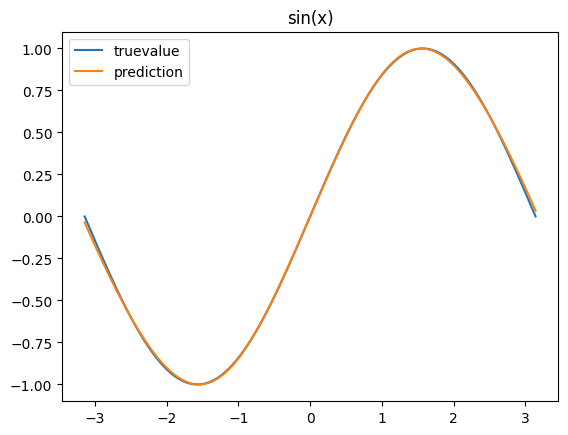

In [7]:
x = (np.arange(-np.pi, np.pi, 0.001)).reshape(-1, 1)
expected = np.sin(x)
res = bpn.BPNForward(x)

plt.title('sin(x)')
plt.plot(x, expected, label='truevalue')
plt.plot(x, res, label='prediction')
plt.legend()
plt.show()

In [8]:
DIR = f"./train"
XTrain = []
YTrain = []
XTest = []
YTest = []
for no in range(12):
    for pic in range(620):
        if np.random.randint(0, 10):
            XTrain.append(list(Image.open(f"{DIR}/{no + 1}/{pic + 1}.bmp").getdata()))
            YTrain.append(int(no))
        else:
            XTest.append(list(Image.open(f"{DIR}/{no + 1}/{pic + 1}.bmp").getdata()))
            YTest.append(int(no))
XTrain, XTest = np.array(XTrain), np.array(XTest)
YTrain, YTest = np.array(YTrain), np.array(YTest)
LenTrain, LenTest = len(YTrain), len(YTest)
ZTrain, ZTest = np.zeros((LenTrain, 12)), np.zeros((LenTest, 12))
for i in range(LenTrain):
    ZTrain[i][YTrain[i]] = 1
for i in range(LenTest):
    ZTest[i][YTest[i]] = 1
XTrain = XTrain / 255
XTest = XTest / 255

bpn2 = BPNetwork([Layer(40, Sigmoid()), Layer(12, Sigmoid())], SoftMaxError())
bpn2.BPNTrain(XTrain, ZTrain, epoches=40000, interval=40, BatchSize=40, LearningRate=0.01)



In [9]:

with open('zjjmodel.pkl', 'wb') as f:
    pickle.dump(bpn2, f)

accuracy: 0.8511198945981555
accuracy: 0.8511198945981555


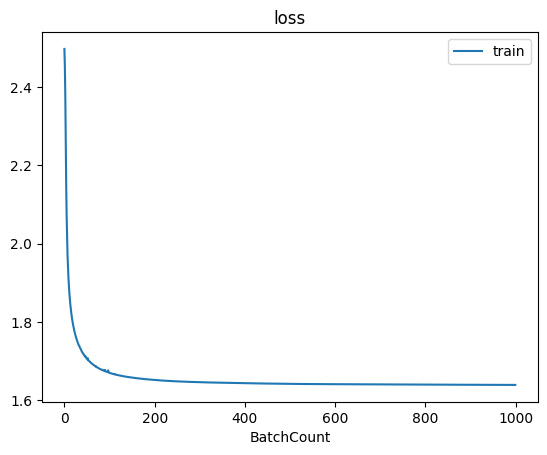

In [13]:
with open('zjjmodel.pkl', 'rb') as f:
    bpn2 = pickle.load(f)

bpn2.BPNPredict(True,XTest, ZTest, cr=YTest)
accuracy = np.equal(np.argmax(bpn2.BPNForward(XTest), axis=1), YTest).sum() / YTest.shape[0]
print(f"accuracy: {accuracy}")



plt.title('loss')
plt.xlabel('BatchCount')
plt.plot(bpn2.Y0, label='train')
plt.legend()
plt.savefig('./final.jpg')


In [7]:
DIR = f"./test_data"

XTest = []
YTest = []
for no in range(12):
    for pic in range(240):

        XTest.append(list(Image.open(f"{DIR}/{no + 1}/{pic + 1}.bmp").getdata()))

        YTest.append(int(no))

XTest = np.array(XTest)/255
YTest = np.array(YTest)

LenTest = len(XTest)
ZTest =np.zeros((LenTest, 12))


for i in range(len(XTest)):
    ZTest[i][YTest[i]] = 1

with open('zjjmodel.pkl', 'rb') as f:
    bpn2 = pickle.load(f)

bpn2.BPNPredict(True,XTest, ZTest, cr=YTest)
accuracy = np.equal(np.argmax(bpn2.BPNForward(XTest), axis=1), YTest).sum() / YTest.shape[0]
print(f"accuracy: {accuracy}")

accuracy: 0.8604166666666667
accuracy: 0.8604166666666667
